In [ ]:
! pip install spark-nlp==4.2.4 pyspark==3.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 448 kB 5.3 MB/s 
     |████████████████████████████████| 281.4 MB 36 kB/s 
     |████████████████████████████████| 198 kB 33.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853643 sha256=77f62fae6caf79cb11bb87b6d024376b9b50c17ab97388cc843526b8e3f5683d
  Stored in directory: /root/.cache/pip/wheels/58/94/83/915c9059e4b038e2d43a6058f307fe1c3e8536e5745f3b23b7
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import pyspark.sql.functions as F

import sparknlp

from sparknlp.annotator import Tokenizer
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Normalizer
from sparknlp.annotator import LemmatizerModel
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
eng_stopwords = stopwords.words('english')
from nltk.corpus import stopwords
from sparknlp.annotator import StopWordsCleaner
from sparknlp.annotator import NGramGenerator
from sparknlp.annotator import PerceptronModel
from sparknlp.base import Finisher
from pyspark.ml import Pipeline
from pyspark.sql import types as T

In [ ]:
!unzip /content/gdrive/Shareddrives/ukraine-russia/ukraine-russia.zip

Archive:  /content/gdrive/Shareddrives/ukraine-russia/ukraine-russia.zip
   creating: ukraine-russia/
  inflating: ukraine-russia/08.csv   
  inflating: __MACOSX/ukraine-russia/._08.csv  
  inflating: ukraine-russia/09.csv   
  inflating: __MACOSX/ukraine-russia/._09.csv  
  inflating: ukraine-russia/02.csv   
  inflating: __MACOSX/ukraine-russia/._02.csv  
  inflating: ukraine-russia/03.csv   
  inflating: __MACOSX/ukraine-russia/._03.csv  
  inflating: ukraine-russia/04.csv   
  inflating: __MACOSX/ukraine-russia/._04.csv  
  inflating: ukraine-russia/10.csv   
  inflating: __MACOSX/ukraine-russia/._10.csv  
  inflating: ukraine-russia/05.csv   
  inflating: __MACOSX/ukraine-russia/._05.csv  
  inflating: ukraine-russia/07.csv   
  inflating: __MACOSX/ukraine-russia/._07.csv  
  inflating: ukraine-russia/06.csv   
  inflating: __MACOSX/ukraine-russia/._06.csv  


In [ ]:
spark = sparknlp.start()

In [ ]:
df = spark.read.csv("./ukraine-russia/08.csv", header=True,  inferSchema=True)
df = df.filter(F.col("language")=="en")

In [ ]:
df = df.filter(F.col("language")=="en")

In [ ]:
df.count()

41358

In [ ]:
def preprocess_data(df):

  df = df.filter(df.text.isNotNull())
  tweet_col = 'text'
  review_text = df.select(tweet_col).filter(F.col(tweet_col).isNotNull())
  clean = review_text.withColumn('text', F.regexp_replace('text', r"http\S+", ''))
  clean = clean.withColumn('text', F.regexp_replace('text', r"\w+followback\w+", ''))
  clean = clean.withColumn('text', F.regexp_replace('text', '#', ''))
  clean = clean.withColumn('text', F.regexp_replace('text', 'RT', ''))
  clean_text = clean.withColumn('text', F.regexp_replace('text', ':', ''))

  documentAssembler = DocumentAssembler() \
     .setInputCol(tweet_col) \
     .setOutputCol('document')

  tokenizer = Tokenizer() \
     .setInputCols(['document']) \
     .setOutputCol('tokenized')

  normalizer = Normalizer() \
     .setInputCols(['tokenized']) \
     .setOutputCol('normalized') \
     .setLowercase(True)

  lemmatizer = LemmatizerModel.pretrained() \
     .setInputCols(['normalized']) \
     .setOutputCol('lemmatized')

  stopwords_cleaner = StopWordsCleaner() \
     .setInputCols(['lemmatized']) \
     .setOutputCol('unigrams') \
     .setStopWords(eng_stopwords)

  ngrammer = NGramGenerator() \
    .setInputCols(['lemmatized']) \
    .setOutputCol('ngrams') \
    .setN(3) \
    .setEnableCumulative(True) \
    .setDelimiter('_')

  pos_tagger = PerceptronModel.pretrained('pos_anc') \
    .setInputCols(['document', 'lemmatized']) \
    .setOutputCol('pos')

  finisher = Finisher() \
     .setInputCols(['unigrams', 'ngrams', 'pos']) 
  
  pipeline = Pipeline() \
     .setStages([documentAssembler,                  
                 tokenizer,
                 normalizer,                  
                 lemmatizer,                  
                 stopwords_cleaner, 
                 pos_tagger,
                 ngrammer,  
                 finisher])
     
  processed_tweet = pipeline.fit(clean_text).transform(clean_text)
  udf_join_arr = F.udf(lambda x: ' '.join(x), T.StringType())
  processed_tweet  = processed_tweet.withColumn('finished_pos', udf_join_arr(F.col('finished_pos')))
  pos_documentAssembler = DocumentAssembler() \
     .setInputCol('finished_pos') \
     .setOutputCol('pos_document')
  pos_tokenizer = Tokenizer() \
     .setInputCols(['pos_document']) \
     .setOutputCol('pos')
  pos_ngrammer = NGramGenerator() \
    .setInputCols(['pos']) \
    .setOutputCol('pos_ngrams') \
    .setN(3) \
    .setEnableCumulative(True) \
    .setDelimiter('_')

  pos_finisher = Finisher() \
     .setInputCols(['pos', 'pos_ngrams']) \

  pos_pipeline = Pipeline() \
     .setStages([pos_documentAssembler,                  
                 pos_tokenizer,
                 pos_ngrammer,  
                 pos_finisher])
     
  processed_tweet = pos_pipeline.fit(processed_tweet).transform(processed_tweet)
  def remove_pos(words, pos_tags):
    return [word for word, pos in zip(words, pos_tags) 
            if pos in ['VB', 'VBP', 'JJ', 'NN', 'NNS']]

  udf_remove_pos = F.udf(remove_pos, T.ArrayType(T.StringType()))
  processed_tweet = processed_tweet.withColumn(
      'filtered_unigrams',
      udf_remove_pos(F.col('finished_unigrams'), F.col('finished_pos'))
  )
  
  def remove_pos_combs(words, pos_tags):
    return [word for word, pos in zip(words, pos_tags) 
            if (len(pos.split('_')) == 2 and \
                pos.split('_')[0] in ['JJ', 'NN', 'NNS', 'VB', 'VBP'] and \
                 pos.split('_')[1] in ['JJ', 'NN', 'NNS']) \
            or (len(pos.split('_')) == 3 and \
                pos.split('_')[0] in ['JJ', 'NN', 'NNS', 'VB', 'VBP'] and \
                pos.split('_')[1] in ['JJ', 'NN', 'NNS', 'VB', 'VBP'] and \
                pos.split('_')[2] in ['NN', 'NNS'])
            ]
    
  udf_remove_pos_combs = F.udf(remove_pos_combs, T.ArrayType(T.StringType()))
  processed_tweet = processed_tweet.withColumn(
      'filtered_ngrams',
      udf_remove_pos_combs(F.col('finished_ngrams'),F.col('finished_pos_ngrams'))
  )
  processed_tweet = processed_tweet.withColumn(
      'final', 
      F.concat(F.col('filtered_unigrams'), 
      F.col('filtered_ngrams'))
  )
  return processed_tweet.select("text", "final")


In [ ]:
processed_tweets = preprocess_data(df)
processed_tweets.show(10,False)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
processed_tweets = processed_tweets.filter(F.size("final")>3)
processed_tweets.show(10, False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
processed_tweets.persist()

DataFrame[text: string, final: array<string>]

In [ ]:
! pip install pyldavis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=7584e32cf658ad928b767429ad71762c93e70f2a1df7f0b248c6823f39d1755c
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=737f52248478c3c56505a346dbfca05405ded051eefebec3d14c29259e0e4926
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyldavis sklearn


In [ ]:
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.ml.clustering import LDA
import pyLDAvis
import numpy as np

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [ ]:
import time

In [ ]:
def fit_lda(df_tweets, num_tweets_to_train=1000):
  tfizer = CountVectorizer(inputCol='final', outputCol='tf_features')
  tf_model = tfizer.fit(df_tweets)
  tf_result = tf_model.transform(df_tweets)

  idfizer = IDF(inputCol='tf_features', outputCol='tf_idf_features')
  idf_model = idfizer.fit(tf_result)
  tfidf_result = idf_model.transform(tf_result)

  num_topics = 5
  max_iter = 25

  print("111")
  start = time.time()
  lda = LDA(k=num_topics, maxIter=max_iter, featuresCol='tf_idf_features')
  lda_model = lda.fit(tfidf_result.limit(num_tweets_to_train))
  end = time.time()
  print(end - start)

  transformed = lda_model.transform(tfidf_result)
  vocab = tf_model.vocabulary

  def get_words(token_list):
      return [vocab[token_id] for token_id in token_list]
        
  udf_to_words = F.udf(get_words, T.ArrayType(T.StringType()))
  num_top_words = 15
  topics = lda_model.describeTopics(num_top_words).withColumn('topicWords', udf_to_words(F.col('termIndices')))

  wc = df_tweets.select((F.explode(df_tweets.final)).alias("words")).groupby("words").count()
  word_counts = {r['words']:r['count'] for r in wc.collect()}
  word_counts = [word_counts[w] for w in tf_model.vocabulary]

  data = {
      'topic_term_dists': np.array(lda_model.topicsMatrix().toArray()).T, 
      'doc_topic_dists': np.array([x.toArray() for x in transformed.select(["topicDistribution"]).toPandas()['topicDistribution']]),
      'doc_lengths': [r[0] for r in df_tweets.select(F.size(df_tweets.final)).collect()],
      'vocab': tf_model.vocabulary,
      'term_frequency': word_counts
  }
  return data



In [ ]:
processed_tweets = processed_tweets.filter(F.size("final")>10)

In [ ]:
k = processed_tweets.limit(50000)
k.persist()

DataFrame[text: string, final: array<string>]

In [ ]:
data = fit_lda(k, num_tweets_to_train=50000)
# py_lda_prepared_data = pyLDAvis.prepare(**data)
# pyLDAvis.display(py_lda_prepared_data)

111
56.22648000717163


In [ ]:
pyLDAvis.save_html(py_lda_prepared_data, 'lda-08.html')


In [ ]:
processed_tweets.show()

+--------------------+--------------------+
|                text|               final|
+--------------------+--------------------+
|UK Defense Secret...|[uk, defense, sec...|
|The only way we c...|[survive, biden, ...|
|US backs creating...|[demilitarized, z...|
|Russian forces ur...|[russian, force, ...|
|Russia has been u...|[use, nuclear, pl...|
|UN Secretary-Gene...|[un, secretarygen...|
|For the First Tim...|[send, gas, russi...|
|While Europe is p...|[dearly, biden, p...|
|The destruction o...|[saki, crimea, ex...|
|Wanna see Zelensk...|[wanna, see, zele...|
|Visiting peace mu...|[visit, peace, mu...|
|Kayleigh McEnany'...|[kayleigh, mcenan...|
|@NotAbouThatBase ...|[notabouthatbase,...|
|Moment Like Firew...|[moment, firework...|
|@dbongino You mig...|[dbongino, read, ...|
|@POTUS If you bla...|[potus, increase,...|
|@RussiaUN @MID_RF...|[russiaun, midrf,...|
|Russian troops co...|[russian, troop, ...|
|@nypost Stinks!  ...|[nypost, stink, m...|
|Destroyed Russian...|[destroy, 

In [ ]:
months = [ "06", "07", "08","09"]

In [ ]:
for month in months:
  df = spark.read.csv(f"./ukraine-russia/{month}.csv", header=True,  inferSchema=True)
  df = df.filter(F.col("language")=="en")
  processed_tweets = preprocess_data(df)
  processed_tweets = processed_tweets.filter(F.size("final")>10)
  data = fit_lda(processed_tweets, num_tweets_to_train=5000)
  py_lda_prepared_data = pyLDAvis.prepare(**data)
  pyLDAvis.display(py_lda_prepared_data)
  pyLDAvis.save_html(py_lda_prepared_data, f'lda-{month}.html')


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]


In [ ]:
import pandas as pd

p = pd.DataFrame({})
p["Tweet Count"] = [100, 500, 1000, 5000, 10000, 20000, 50000]
p["Python"] = [1.1, 3.5, 12.3, 37.7, 68.5, 108.6, 260.8]
p["PySpark"] = [4.5, 4.4, 4.5, 11.9, 21.1, 44.5, 56.9]

In [ ]:
p

,Tweet Count,Python,PySpark
0,100,1.1,4.5
1,500,3.5,4.4
2,1000,12.3,4.5
3,5000,37.7,11.9
4,10000,68.5,21.1
5,20000,108.6,44.5
6,50000,260.8,56.9


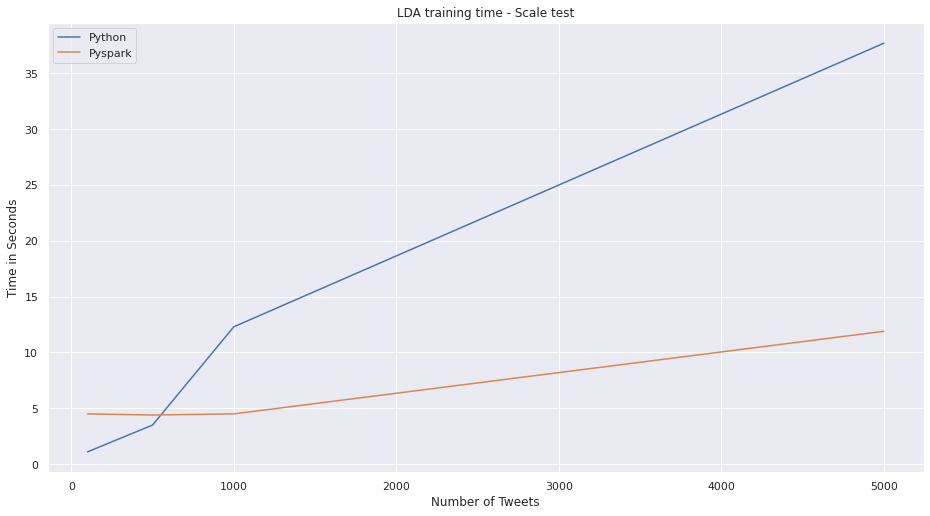

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})

# loading dataset
  
# draw lineplot
sns.lineplot(x="Tweet Count", y="Python", data=p[:4],  label="Python")
sns.lineplot(x="Tweet Count", y="PySpark", data=p[:4],  label="Pyspark")
plt.ylabel("Time in Seconds")
plt.xlabel("Number of Tweets")
plt.title('LDA training time - Scale test')
plt.show()

In [ ]:
# Python implementation

In [ ]:
import pandas as pd
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim import corpora
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()


df = pd.read_csv("./ukraine-russia/08.csv")
k = df[~df['text'].isna()]

# Create a corpus from a list of texts
common_dictionary = Dictionary(k[:5000]["text"])
common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=5)
def clean(doc):
    stop_free = ' '.join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join([ch for ch in stop_free if ch not in exclude])
    normalized = ' '.join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized
doc_clean = [clean(doc).split() for doc in k["text"][:50000]]

dictionary = corpora.Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

Lda = gensim.models.ldamodel.LdaModel
start = time.time()
ldamodel = Lda(doc_term_matrix, num_topics = 5, id2word = dictionary, passes=25)
end = time.time()
print(end-start)